In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from typing import Optional, Callable, List, Dict
import sys
import logging

import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('..')

In [91]:
from src.data import load_data
from src import config
from src.preprocessing.dataset import generate_dataset

In [114]:
PERIOD = 96

LOC_X = 200
LOC_Y = 200

DATASET_SIZE = -1
NUMBER_TO_GENERATE = PERIOD * 10
SHIFT_SIZE = PERIOD

ADD_IS_DAY = True

In [115]:
assert DATASET_SIZE > NUMBER_TO_GENERATE + SHIFT_SIZE or DATASET_SIZE==-1

train_data = load_data("../data", 2020)[:DATASET_SIZE, 200, 200]
test_data = load_data("../data", 2019)[:DATASET_SIZE, 200, 200]

print(train_data.shape, test_data.shape)

(35135,) (35039,)


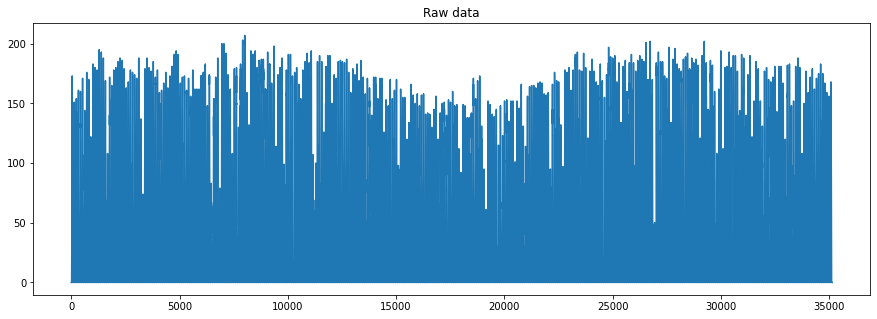

In [116]:
plt.figure(figsize=(15,5))
plt.plot(train_data)
plt.title('Raw data')
plt.show()

In [117]:
X_train, y_train = generate_dataset(
    train_data, shift=SHIFT_SIZE, make_diff=False, add_is_day=ADD_IS_DAY, remove_some_0=True
)
X_test, y_test = generate_dataset(
    test_data, shift=SHIFT_SIZE, make_diff=False, add_is_day=ADD_IS_DAY, remove_some_0=False
)

# If we have added the day, we have one more column
if ADD_IS_DAY:
    SHIFT_SIZE+=1
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(19227, 193) (19227,)
(34847, 193) (34847,)


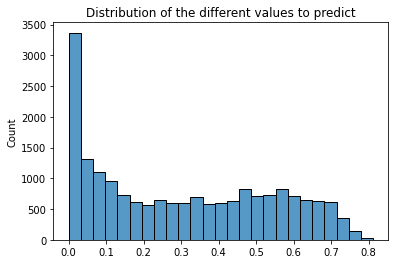

In [118]:
plt.figure()
plt.title('Distribution of the different values to predict')
sns.histplot(y_train);

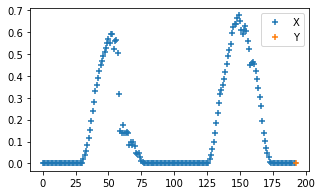

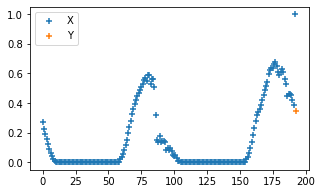

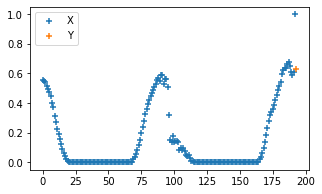

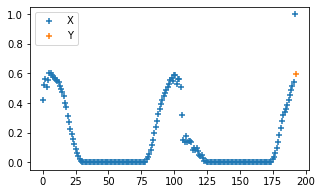

In [119]:
step = 10
for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i % step != 0:
        continue
    plt.figure(figsize=(5, 3))
    plt.scatter(np.array(range(x.shape[0])), x, label="X", marker="+")
    plt.scatter([x.shape[0]], y, label="Y", marker="+")
    plt.legend()
    plt.title(f"")
    if i > step * 2:
        break


## Model

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [121]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=2),
    #"DecisionTreeRegressor2": DecisionTreeRegressor(max_depth=10),
    "DecisionTreeRegressor3": DecisionTreeRegressor(max_depth=100),
    "DecisionTreeRegressor4": DecisionTreeRegressor(max_depth=500),
    "PolynomialRegression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "XGB": GradientBoostingRegressor(n_estimators=100, max_depth=2),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=2),
}

del models['PolynomialRegression'] # We don't want to test this one, goes to crazy

In [150]:
selected_models_checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=selected_models_checkboxes)
display(output)

In [151]:
selected_models = set([
    checkbox.description for checkbox in selected_models_checkboxes if checkbox.value
])
print(f"Running the evaluation with {', '.join(selected_models)}")

models = {k:v for k,v in models.items() if k in selected_models}

Running the evaluation with DecisionTreeRegressor4, DecisionTreeRegressor, XGB, DecisionTreeRegressor3, RandomForest


In [152]:
for model_name, model in models.items():
    print(model_name)
    model.fit(X_train, y_train)
print('Done !')

DecisionTreeRegressor
DecisionTreeRegressor3
DecisionTreeRegressor4
XGB
RandomForest
Done !


In [154]:
IDX = 10

x_initial = X_test[IDX]
y_truth = y_test[IDX:IDX+NUMBER_TO_GENERATE]

# Check the sizes
assert x_initial.shape == (SHIFT_SIZE,), f"{x_initial.shape} != ({SHIFT_SIZE},)"
assert y_truth.shape == (NUMBER_TO_GENERATE,), f"{y_truth.shape} != ({NUMBER_TO_GENERATE},)"

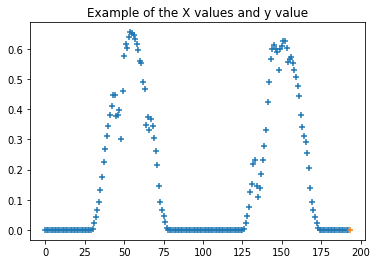

In [155]:
plt.scatter(range(x_initial.shape[0]), x_initial, marker="+")
plt.scatter([x_initial.shape[0]], y_truth[:1], marker="+")
plt.title("Example of the X values and y value")
plt.show();

In [156]:
def predict_next_values(pred_func: Callable, x_initial: np.ndarray, how_many: int):
    """Predict the next values."""
    size = SHIFT_SIZE
    predictions = np.zeros((1, size+how_many))
    predictions[0,:size] = x_initial[-size:]
    
    try:
        for i in tqdm(range(how_many)):
            x = predictions[:,i:i+size]
            predictions[0,size + i] = pred_func(x)[0]
    except Exception as e:
        print(e)
    return predictions[0,size:]

In [157]:
def plot_prediction(x_initial: np.ndarray, y_truth: np.ndarray, y_preds: Dict[str, np.ndarray]):
    """Plot the prediction."""
    plt.figure(figsize=(30, 20))
    plt.ylim(-0.5, 2)
    plt.plot(x_initial, label="Initial values", marker="+")
    idx = np.array(range(x_initial.shape[0]+1, x_initial.shape[0] + y_truth.shape[0]+1))
    plt.plot(idx, y_truth, label="Truth", marker="+")
    

    for model_name, y_pred in y_preds.items():
        plt.plot(idx, y_pred, label=f"Prediction with {model_name}", marker="+")

    plt.grid()
    plt.legend()
    plt.show()


In [158]:
print('Predictions to display')
checkboxes = [widgets.Checkbox(value=True, description=label) for label in models]
output = widgets.VBox(children=checkboxes)
display(output)

Predictions to display


In [159]:
selected_models = set([
    checkbox.description for checkbox in checkboxes if checkbox.value
])
print(f"Prediction and display the following models: {', '.join(selected_models)}")

Prediction and display the following models: DecisionTreeRegressor4, DecisionTreeRegressor, XGB, DecisionTreeRegressor3, RandomForest


In [160]:
predictions = {
    model_name: predict_next_values(model.predict, x_initial, NUMBER_TO_GENERATE)
    for model_name, model in models.items()
    if model_name in selected_models
}

100%|██████████| 960/960 [00:10<00:00, 91.29it/s] 


DecisionTreeRegressor     3258.561316
DecisionTreeRegressor3    6378.872917
DecisionTreeRegressor4    6796.191667
XGB                       4108.557892
RandomForest              3243.830386
dtype: float64


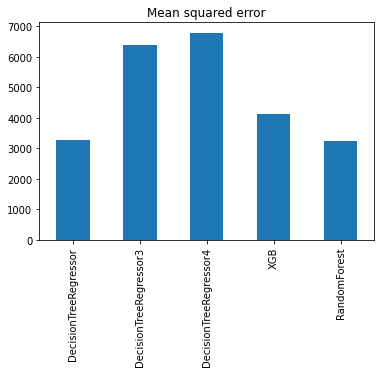

In [161]:
from sklearn.metrics import mean_squared_error
metrics = pd.Series({
    model_name: mean_squared_error(255*y_truth, 255*pred)
    for model_name, pred in predictions.items()
    if model_name in selected_models
})
print(metrics)
metrics.plot(kind='bar')
plt.title("Mean squared error")
plt.show()

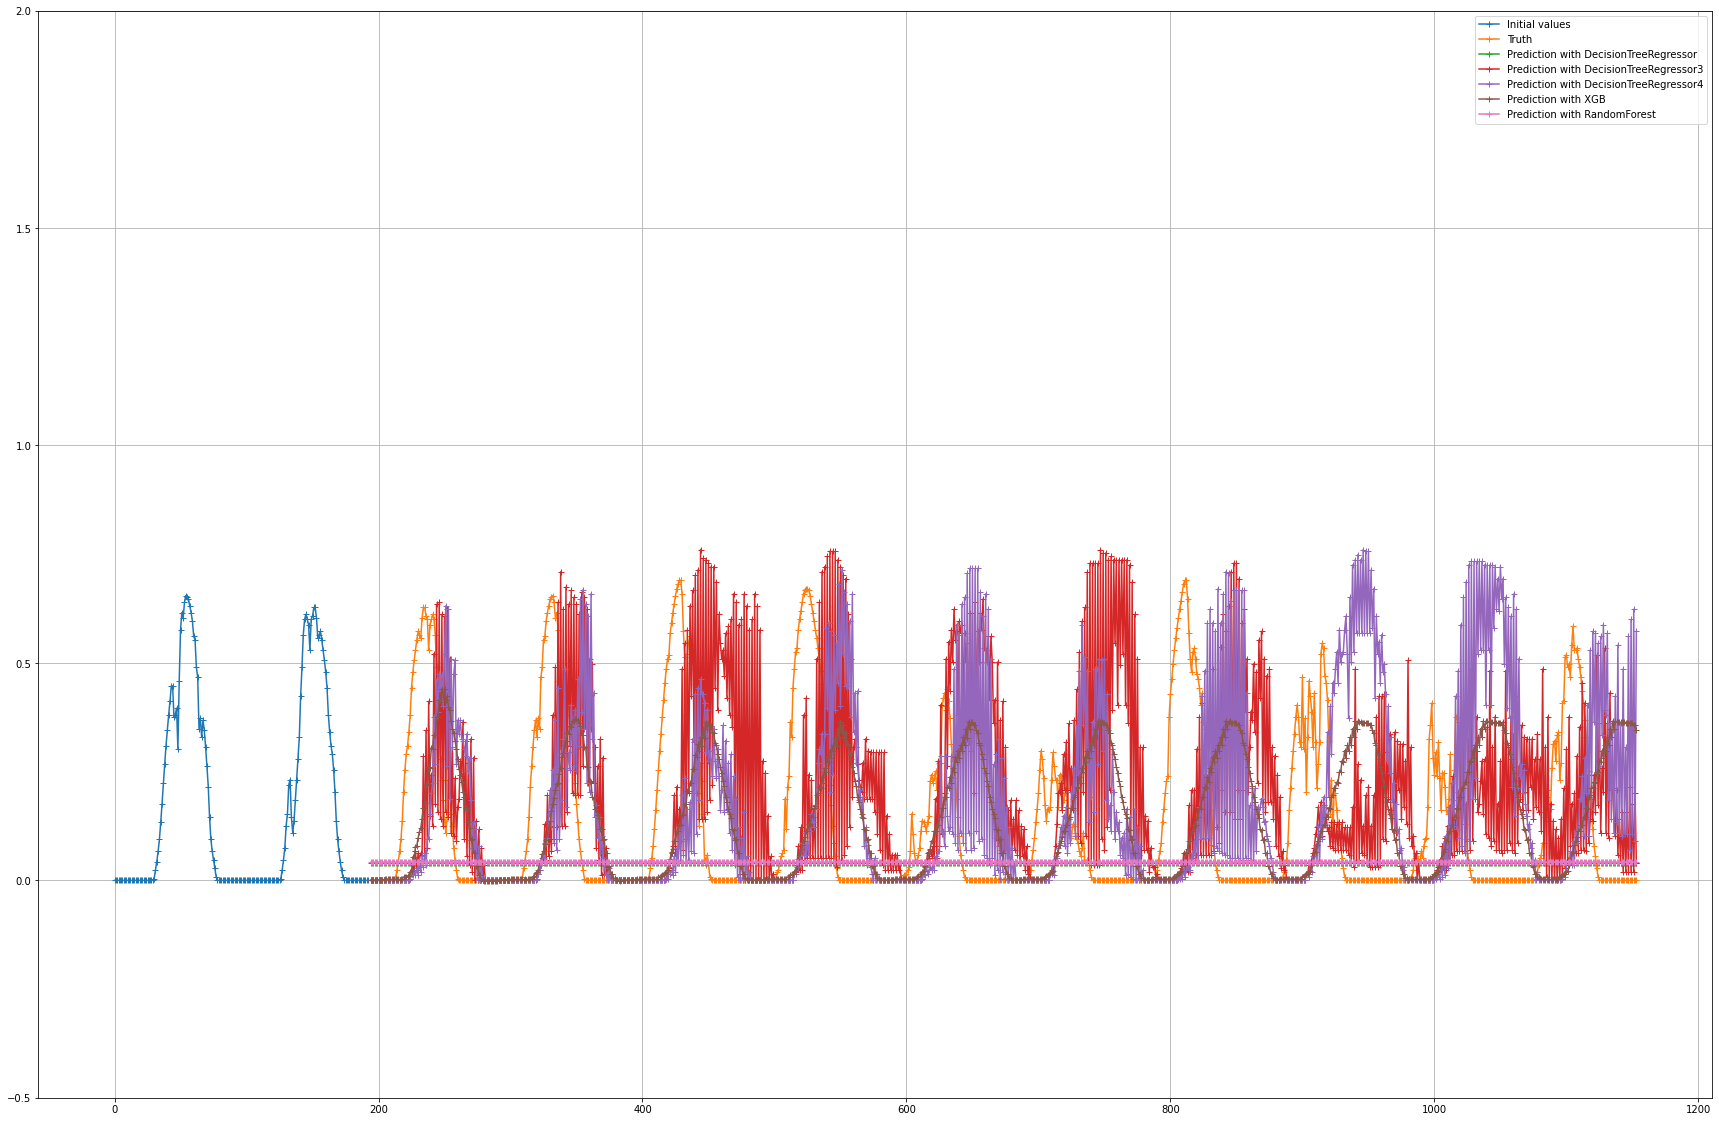

In [162]:
plot_prediction(
    x_initial,
    y_truth,
    predictions
)


# Models explicability

In [165]:
print(models.keys())

dict_keys(['DecisionTreeRegressor', 'DecisionTreeRegressor3', 'DecisionTreeRegressor4', 'XGB', 'RandomForest'])


In [166]:
MODEL_NAME = "DecisionTreeRegressor3"

In [167]:
model = models[MODEL_NAME]

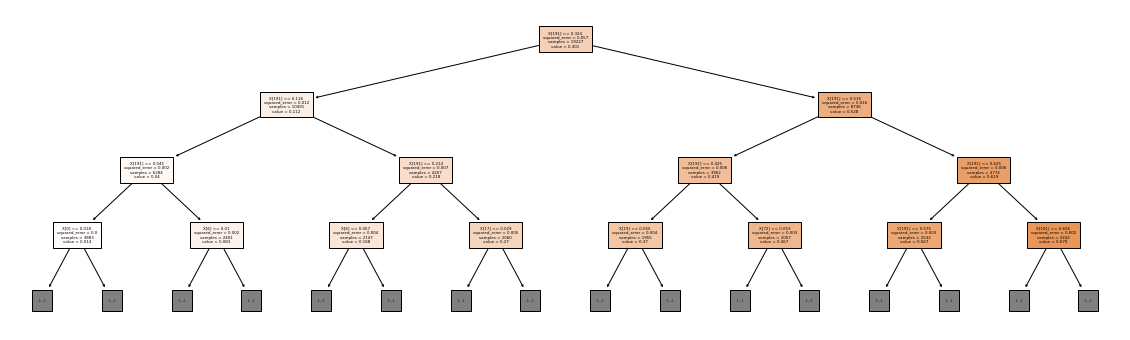

In [168]:
if isinstance(model, DecisionTreeRegressor):
    # plot model decision tree
    from sklearn.tree import plot_tree

    plt.figure(figsize=(20,6))
    plot_tree(model, filled=True, max_depth=3, fontsize=4)
    plt.savefig(f'./model_tree_{MODEL_NAME}.png')
    plt.show()

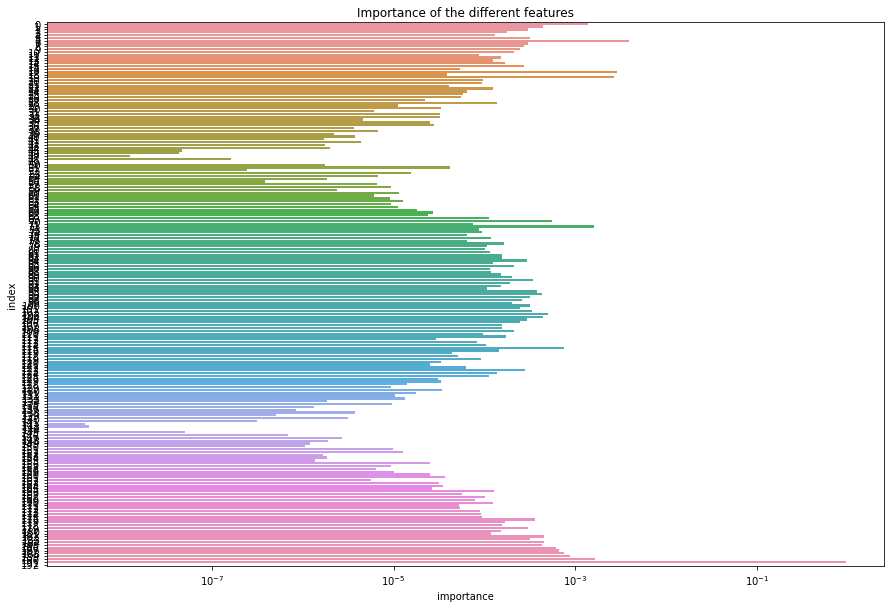

In [169]:
if isinstance(model, DecisionTreeRegressor):
    df = pd.DataFrame({
        "importance": model.feature_importances_
    }).reset_index()
    plt.figure(figsize=(15,10))
    sns.barplot(
        data=df,
        y="index",
        x="importance",
        orient="h"
    );
    plt.title('Importance of the different features')
    # set log y axis
    plt.xscale("log")

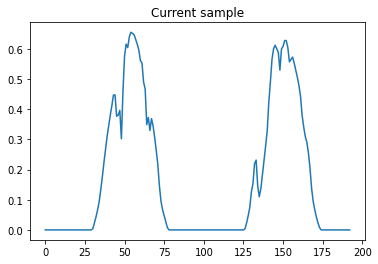

In [170]:
plt.plot(X_test[0])
plt.title('Current sample')
plt.show()

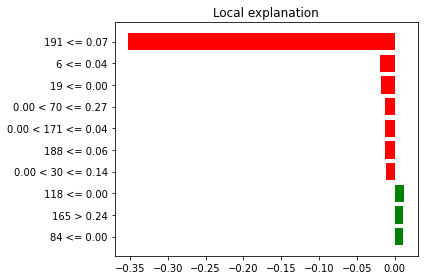

In [171]:
import lime
from lime import lime_tabular
import numpy as np

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    mode="regression",
)

exp = explainer.explain_instance(X_test[0], predict_fn=model.predict)

exp.as_pyplot_figure()
import matplotlib.pyplot as plt
plt.tight_layout()

  0%|          | 0/40 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  2%|▎         | 1/40 [00:01<00:42,  1.09s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

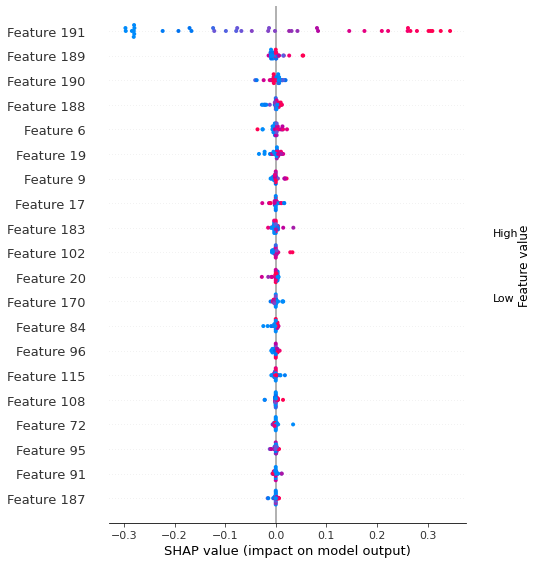

In [172]:
import shap
train = shap.sample(X_train,40)
shap_explainer = shap.KernelExplainer(model.predict, train)
shap_values = shap_explainer.shap_values(train)
shap.summary_plot(shap_values, train)

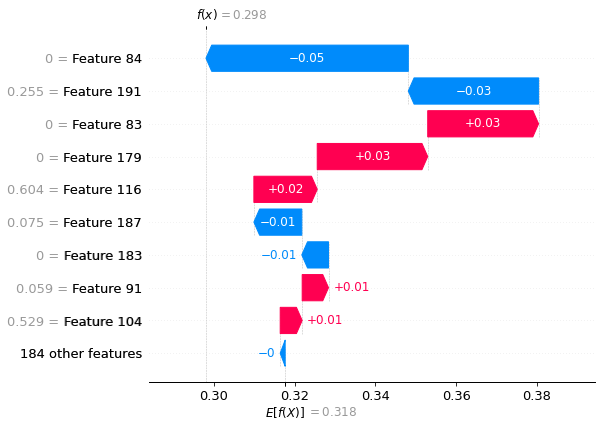

In [173]:
shap_explainer = shap.Explainer(model.predict, train)
shap_values = shap_explainer(train)
shap.plots.waterfall(shap_values[0])

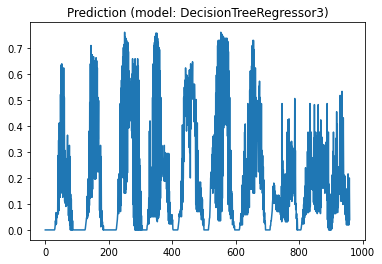

In [174]:
prediction = predictions[MODEL_NAME]
plt.figure()
plt.title(f"Prediction (model: {MODEL_NAME})")
plt.plot(prediction);

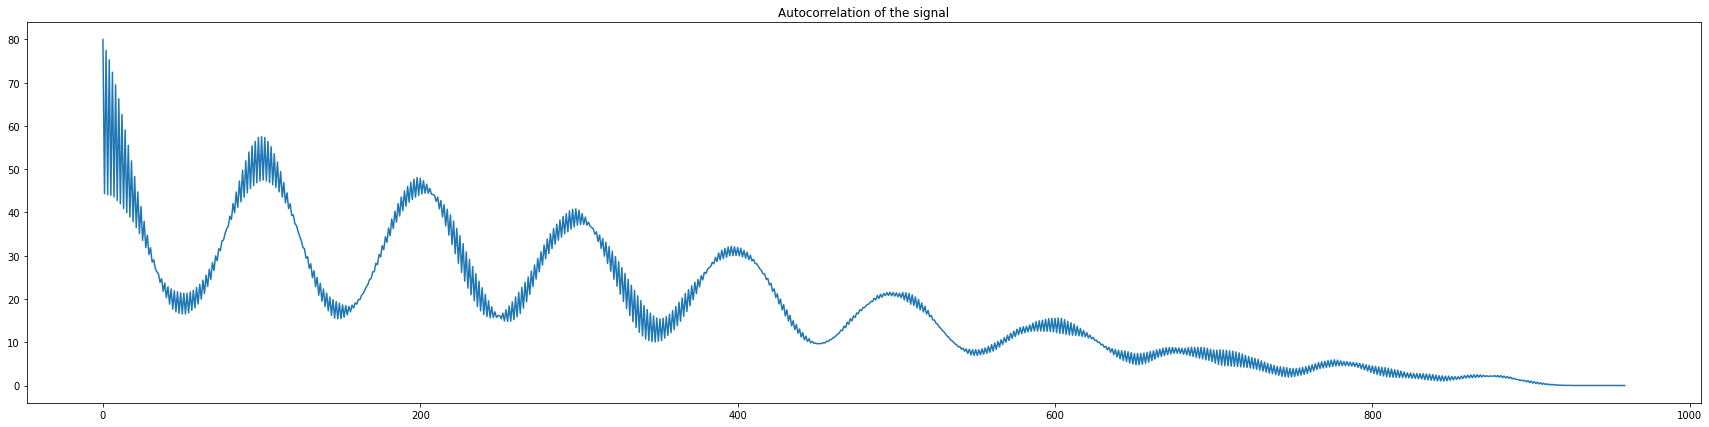

In [175]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

corr = autocorr(prediction)
plt.figure(figsize=(30,7))
plt.title('Autocorrelation of the signal')
plt.plot(corr)
plt.show()